In [1]:
import math
import importlib

import pickle

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client, get_full_strategy
from src.toy_functions import Hartmann6D
import pickle

silence_ax_client()


-0.0 -0.9874311636230129


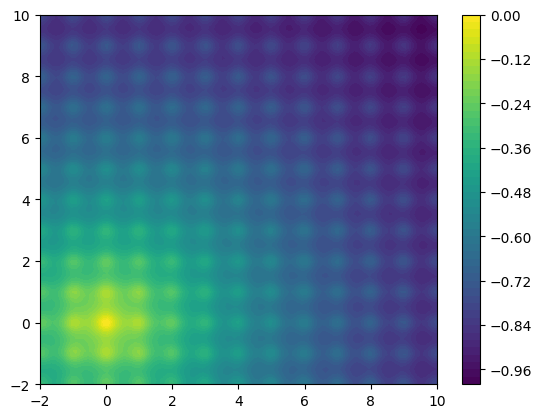

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  25.602607   4.522749
2         2_0   5.947160  10.606390
3         3_0   1.821155   2.455960
4         4_0  83.613708  57.590595
5         5_0  44.154106   1.326668
6         6_0   1.110248  55.322338
7         7_0   3.627137   7.185474
8         8_0  13.518196  29.964873
9         9_0  12.270544   2.223205
10       10_0   5.233669  94.375207
11       11_0   1.724897   4.104461
12       12_0  37.223357  17.425131
13       13_0  71.788133   7.530235
14       14_0   2.879945  17.977169
15       15_0   8.739423   1.386822
16       16_0  23.655034  33.105972
17       17_0  18.538886   1.710818
18       18_0   8.213158  40.293488
19       19_0   2.701950   9.965889
20       20_0  56.356899  23.472787
21       21_0  34.357411   3.251325
22       22_0   1.426825  13.618148
23       23_0   4.336551   1.897813
24       24_0  11.306761  79.483190
25       25_0  16.940978   5.864042
26       26_0   3.790807  25

<Axes: xlabel='x0', ylabel='x1'>

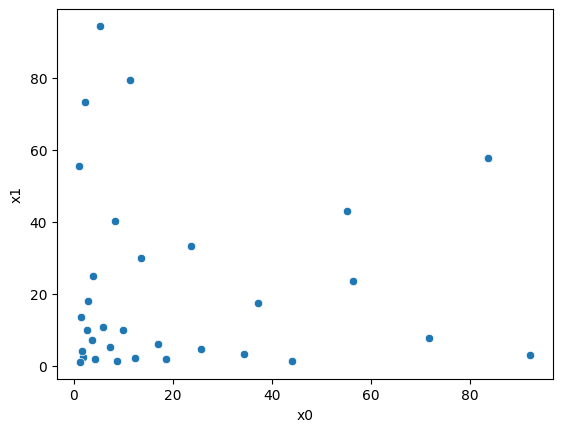

In [3]:
client = Client()


client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling="log",
        )
        for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

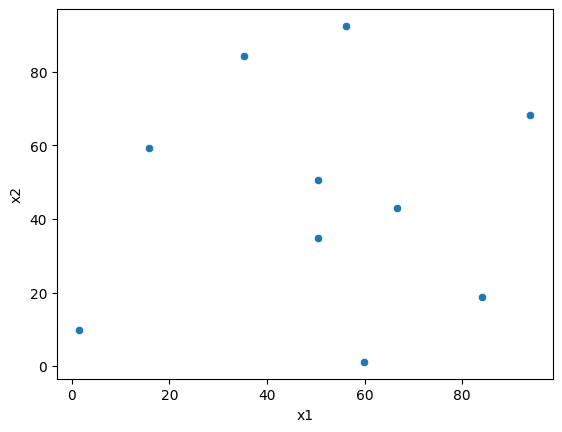

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\GitHub\bo-coli\src\model_generation.py:62: UserWarning:

std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}>,
        <Axes: title={'center': 'GP along x2'}>], dtype=object))

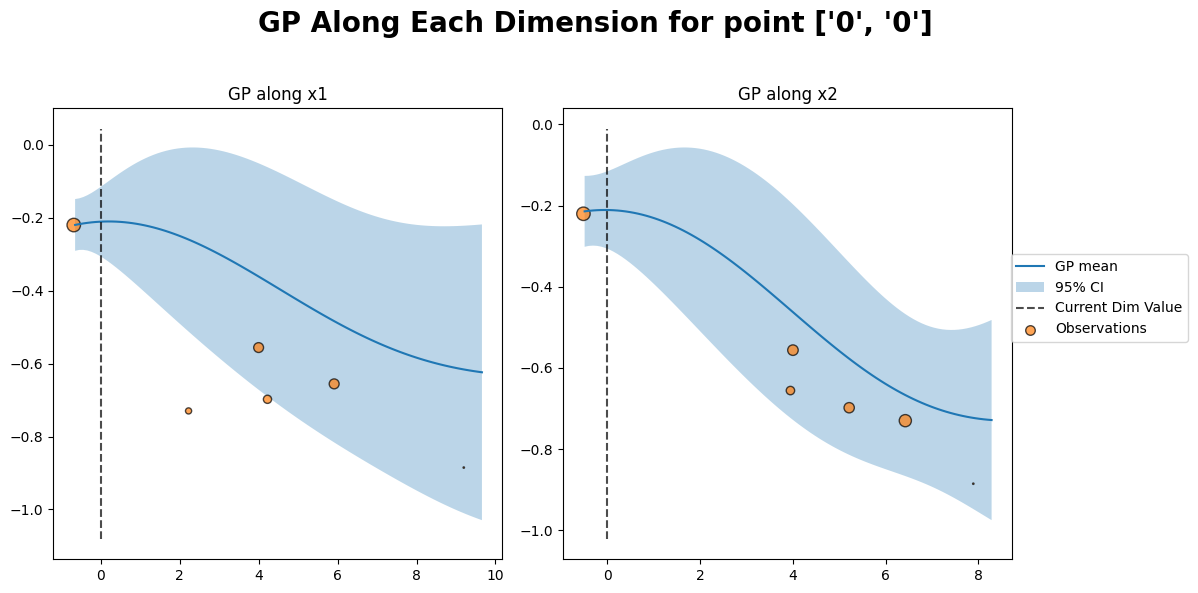

In [5]:

from src import ax_helper
importlib.reload(GPVisualiser)

client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)


batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client)
plotter = GPVisualiser.GPVisualiserMatplotlib.init_from_client(client)
plotter.plot_all([0,0])

In [6]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,9.197429,7.889881,-0.885096
2,2_0,-0.683252,-0.519040,-0.220142
3,3_0,2.225357,6.423596,-0.729783
4,4_0,5.913775,3.945782,-0.655623
5,5_0,4.224877,5.212799,-0.697907


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

In [8]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [9]:

pickle.dump(batch_handler.client, open("data/ax_clients/ackley_client.pkl", "wb"))

In [10]:
pickle.load(open("data/ax_clients/ackley_client.pkl", "rb"))

In [11]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,9.197429,7.889881,-0.885096
2,2_0,-0.683252,-0.519040,-0.220142
3,3_0,2.225357,6.423596,-0.729783
4,4_0,5.913775,3.945782,-0.655623
5,5_0,4.224877,5.212799,-0.697907


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [12]:
range_parameters = [
    RangeParameterConfig(name="x1", parameter_type="float", bounds=(-2, 10))
]

metric_name = "response"
dim_names = ["x1"]


def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x, y: y + np.random.normal(0, 1)


def plot_test(fig=None):
    if fig:
        import plotly.graph_objects as go


        fig.add_trace(go.Scatter(
            x=np.linspace(-2, 10, 100),
            y=[test_function(x) for x in np.linspace(-2, 10, 100)],
            mode="lines",
            name="True function",
            line=dict(color="black")
        ))
        fig.show()
    else:
        plt.plot(
            np.linspace(-2, 10, 100),
            [test_function(x) for x in np.linspace(-2, 10, 100)],
            color="black",
            label="True function",
        )



In [13]:
from src import ax_helper
importlib.reload(ax_helper)

<module 'src.ax_helper' from 'c:\\GitHub\\bo-coli\\src\\ax_helper.py'>

In [14]:
tester = ax_helper.SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)


In [15]:
fig = runs.plot_GP(SingleTaskGP)
plot_test(fig)

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

In [16]:
from src import model_generation as mg
importlib.reload(mg)


runs = tester.run(
    mg.GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(mg.GammaNoiseSGP)


plot_test(runs)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

In [17]:
runs = tester.run(mg.GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(mg.GammaNoiseSGP, figsize=(8, 4))
plot_test(runs)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Heteroscedastic noise

In [18]:
def noise_fn_low(x, y= None):
    return y + np.random.normal(0, 1)*(x['x1']+2)/12


runs = tester.run(mg.GammaNoiseSGP, n_runs=4, technical_repeats=3, batch_size=3, noise_fn=noise_fn_low, plot_each=False)
fig =runs.plot_GP(mg.GammaNoiseSGP, figsize=(12, 6))
plot_test(fig)

* The white noise kernel is unable to accommodate linear heteroscedastic noise.

## Technical repeat adaptive kernel

In [19]:
importlib.reload(mg)
fig = runs.plot_GP(mg.HeteroNoiseSGP, figsize=(12, 6))
plot_test(fig)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



* Fitting a gp to pre-investigated data appear perform quite badly 

## Heteroscedastic + fixed white noise

In [ ]:
fig = runs.plot_GP(mg.HeteroWhiteSGP, figsize=(12, 6))
plot_test(fig)

Much better performance when data is acquired during the run.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [21]:


save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701732418,
 3.4166377701

In [22]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = ax_helper.SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

## Sequential runs no noise

In [23]:
def noise_fn(x, y):
    return y

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=40, technical_repeats=2, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP)

* Save the data for our testing purposes

In [24]:
client_dir = r"data/ax_clients/"
runs.client.save_to_json_file(client_dir + "hartmann6_runs.json")

In [25]:
client._experiment.parameters.keys()

dict_keys(['x1', 'x2'])

In [26]:
dir(client._experiment)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arms_by_name',
 '_arms_by_signature',
 '_attach_trial',
 '_cache_metric_fetch_error',
 '_check_TTL_on_running_trials',
 '_data_by_trial',
 '_db_id',
 '_default_data_type',
 '_eq_skip_db_id_check',
 '_experiment_type',
 '_fetch_trial_data',
 '_get_last_data_without_similar_rows',
 '_initial_auxiliary_experiments_by_purpose',
 '_is_test',
 '_lookup_or_fetch_trials_results',
 '_metric_fetching_errors',
 '_metrics_by_class',
 '_name',
 '_name_and_store_arm_if_not_exists',
 '_optimization_config',
 '_properties',
 '_register_

In [27]:
client._experiment.metrics

{'response': MapMetric('response')}

In [28]:
client = Client().load_from_json_file(client_dir + "hartmann6_runs.json")
ax_helper.get_obs_from_client(client)

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
1,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
2,2_0,0.512098,0.996020,0.867878,0.176255,0.239070,0.617973,0.109368
3,2_0,0.512098,0.996020,0.867878,0.176255,0.239070,0.617973,0.109368
4,4_0,0.308241,0.031998,0.213598,0.978520,0.906073,0.144178,0.001924
...,...,...,...,...,...,...,...,...
76,76_0,0.000000,0.580029,0.368198,0.000000,0.450381,0.348963,0.307659
77,76_0,0.000000,0.580029,0.368198,0.000000,0.450381,0.348963,0.307659
78,78_0,0.908832,0.638037,0.000000,0.968266,0.810486,0.667837,0.000054
79,78_0,0.908832,0.638037,0.000000,0.968266,0.810486,0.667837,0.000054
